In [36]:
import warnings
from collections import Counter
from datetime import timedelta
from enum import Enum

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud


stopwords = stopwords.words("english")


class Sentiment(Enum):
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"
    POSITIVE = "POSITIVE"
    MIXED = "MIXED"


sns.set_palette("mako")

warnings.filterwarnings("ignore")

MONTH = "October"


In [37]:
# load data
# df = pd.read_csv(r"aws and vader_oct_result.csv")
df = pd.read_csv(r"Final__oct_result.csv")
df.shape


(31650, 24)

In [38]:
df.columns


Index(['User', 'Date_Created', 'Follows_Count', 'Friends_Count',
       'Retweet_Count', 'Language', 'Date_Tweet', 'Number_of_Likes',
       'Source_of_Tweet', 'Tweet_Id', 'Tweet', 'Hashtags', 'Conversation_Id',
       'In_reply_To', 'Coordinates', 'Place', 'Date_Tweet1', 'lower',
       'cleaned_text', 'Sentiment', 'vader', 'textblob', 'xgb',
       'Majority_label'],
      dtype='object')

In [39]:
# drop Sentiment and rename Majority_label to Sentiment
df = df.drop(columns=["Sentiment"])
df = df.rename(columns={"Majority_label": "Sentiment"})
df["Sentiment"].value_counts()


NEUTRAL     15328
NEGATIVE    14846
POSITIVE     1476
Name: Sentiment, dtype: int64

In [40]:
# make date to datetime
df["Date_Tweet"] = pd.to_datetime(df["Date_Tweet"])
df["Date_Tweet"].describe()


count                         31650
unique                        31304
top       2022-10-11 07:17:28+00:00
freq                              5
first     2022-10-01 00:02:11+00:00
last      2022-10-31 23:59:45+00:00
Name: Date_Tweet, dtype: object

In [41]:
file = "stop_words_for_vis.txt"
with open(file, "r") as f:
    additional_stop_words = f.read().splitlines()


stopwords.extend(additional_stop_words)


In [42]:
df_neg = df[df["Sentiment"] == Sentiment.NEGATIVE.name]
df_pos = df[df["Sentiment"] == Sentiment.POSITIVE.name]
df_neu = df[df["Sentiment"] == Sentiment.NEUTRAL.name]


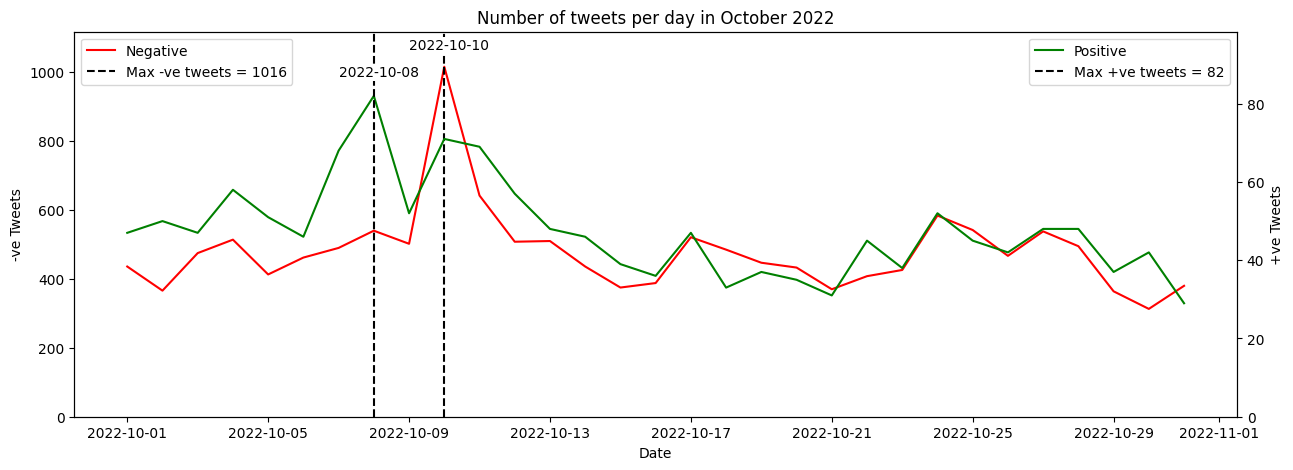

In [43]:
df_neg_count = df_neg.groupby(df.Date_Tweet.dt.date).count()["Tweet_Id"]
df_pos_count = df_pos.groupby(df.Date_Tweet.dt.date).count()["Tweet_Id"]

# max number of tweets per day
max_neg = df_neg_count.max()
max_pos = df_pos_count.max()

fig, host = plt.subplots(figsize=(15, 5))

par1 = host.twinx()

host.set_ylim(0, max_neg * 1.1)
par1.set_ylim(0, max_pos * 1.2)

host.set_xlabel("Date")
host.set_ylabel("-ve Tweets")
par1.set_ylabel("+ve Tweets")

# plot negative tweets
host.plot(df_neg_count, color="red", label="Negative")

# plot positive tweets
par1.plot(df_pos_count, color="green", label="Positive")

# plot max dotted line where the date is max
host.axvline(
    df_neg_count.idxmax(),
    linestyle="--",
    color="k",
    label=f"Max -ve tweets = {max_neg}",
)
par1.axvline(
    df_pos_count.idxmax(),
    linestyle="--",
    color="k",
    label=f"Max +ve tweets = {max_pos}",
)


# label the max line
host.text(
    df_neg_count.idxmax() - timedelta(days=1),
    max_neg + 50,
    df_neg_count.idxmax(),
    bbox=dict(boxstyle="square,pad=0.1", fc="white", ec="none"),
)
par1.text(
    df_pos_count.idxmax() - timedelta(days=1),
    max_pos + 5,
    df_pos_count.idxmax(),
    bbox=dict(boxstyle="square,pad=0.1", fc="white", ec="none"),
)

# lns = [p1, p2]
# host.legend(handles=lns, loc='best')
host.legend(loc="upper left")
par1.legend(loc="upper right")


# title
plt.title(f"Number of tweets per day in {MONTH} 2022")
plt.show()


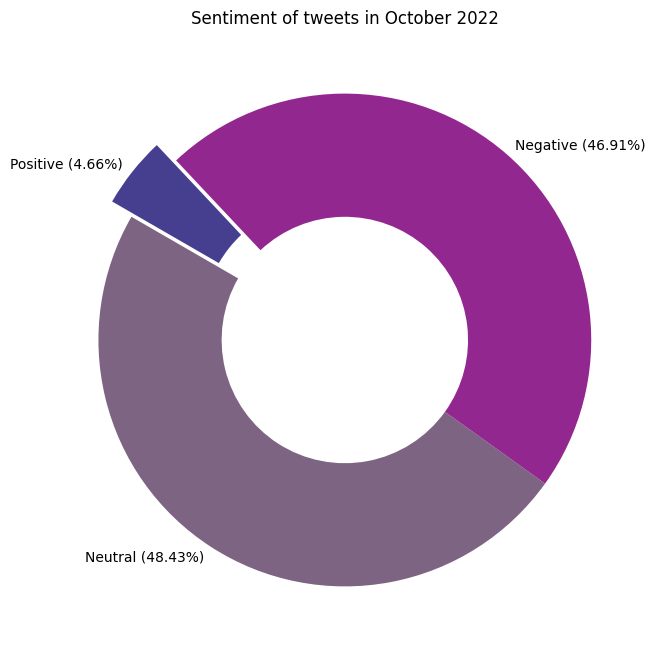

In [44]:
df_pie = df[df["Sentiment"] != Sentiment.MIXED.name]

# labels
labels = df_pie["Sentiment"].value_counts().index.tolist()

# add in brackets the % of each sentiment with each label
labels = [
    f'{label} ({round(df_pie["Sentiment"].value_counts()[label]/len(df_pie)*100, 2)}%)'.capitalize()
    for label in labels
]

# colors from the color palette
colors = {
    Sentiment.NEUTRAL: "#7e6483",
    Sentiment.NEGATIVE: "#932790",
    Sentiment.POSITIVE: "#463f90",
}

plt.figure(figsize=(8, 8))
plt.pie(
    df_pie["Sentiment"].value_counts(),
    labels=labels,
    labeldistance=1.05,
    startangle=150,
    explode=(0.0, 0.0, 0.1),
    colors=colors.values(),
    wedgeprops=dict(width=0.5),
)
plt.title(f"Sentiment of tweets in {MONTH} 2022")
plt.show()


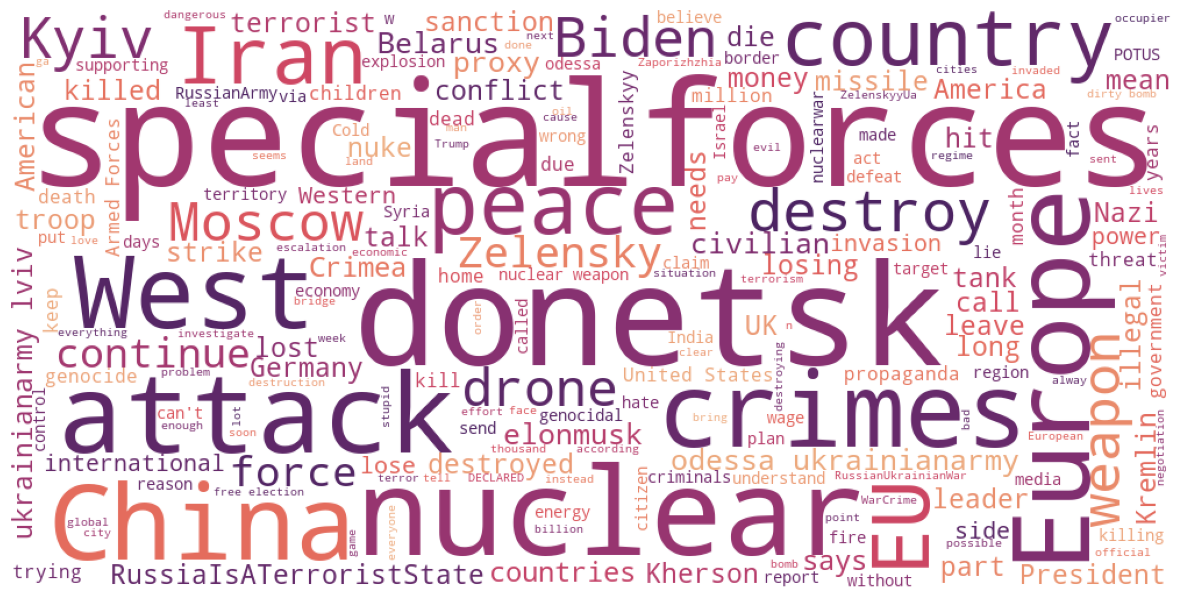

In [45]:
# wordcloud of negative tweets
wordcloud = WordCloud(
    stopwords=stopwords, background_color="white", width=1000, height=500
).generate(" ".join(df_neg["Tweet"].tolist()))

# recolor wordcloud and show
wordcloud.recolor(colormap="flare")

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


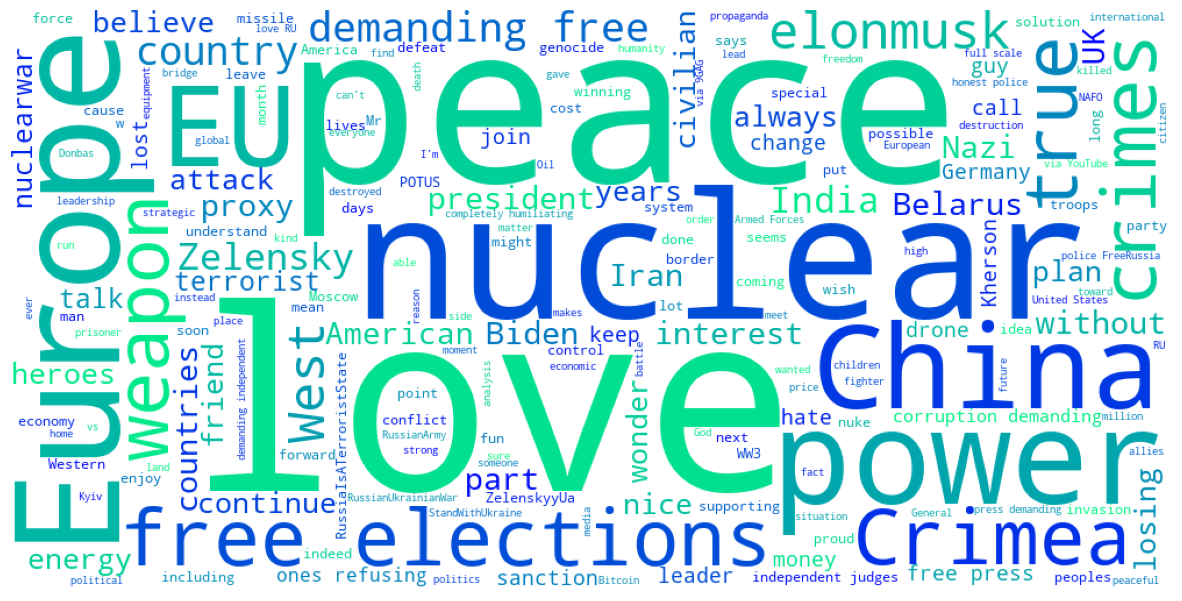

In [46]:
# wordcloud of positive tweets
wordcloud = WordCloud(
    stopwords=stopwords, background_color="white", width=1000, height=500
).generate(" ".join(df_pos["Tweet"].tolist()))

# recolor wordcloud and show
wordcloud.recolor(colormap="winter")

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


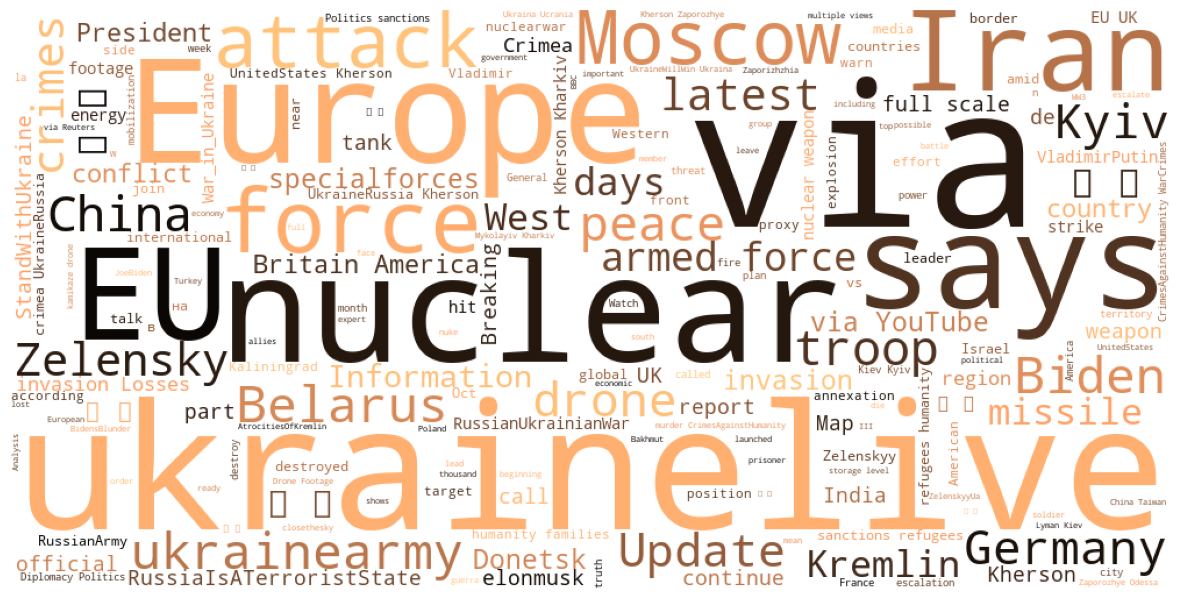

In [47]:
# wordcloud of neutral tweets
wordcloud = WordCloud(
    stopwords=stopwords, background_color="white", width=1000, height=500
).generate(" ".join(df_neu["Tweet"].tolist()))

# recolor wordcloud and show
wordcloud.recolor(colormap="copper")

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [48]:
# count number of words for negative tweets


def count_words(text):
    # split text into words
    words = word_tokenize(text)

    needed_words = []
    for word in words:
        word = word.lower()
        # continue if word is not punctuation
        if not word.isalpha():
            continue
        # check if word is in stopwords
        if word in stopwords:
            continue
        # add word to needed_words
        needed_words.append(word)
    return needed_words


counter_neg = Counter()
for index, row in df_neg.iterrows():
    counter_neg.update(count_words(row["Tweet"]))


counter_pos = Counter()
for index, row in df_pos.iterrows():
    counter_pos.update(count_words(row["Tweet"]))

counter_neu = Counter()
for index, row in df_neu.iterrows():
    counter_neu.update(count_words(row["Tweet"]))


In [49]:
top_50_neg = counter_neg.most_common(50)
top_50_pos = counter_pos.most_common(50)

# set of top 50 words for negative tweets
top_50_neg_set = set(word for word, _ in top_50_neg)
top_50_pos_set = set(word for word, _ in top_50_pos)

# mutually exclusive words
mutual_exclusive_neg = top_50_neg_set.difference(top_50_pos_set)
mutual_exclusive_pos = top_50_pos_set.difference(top_50_neg_set)

# common words
top_common_words = top_50_neg_set.intersection(top_50_pos_set)

# print
print(mutual_exclusive_neg)
print(mutual_exclusive_pos)


{'destroyed', 'ukrainianarmy', 'bridge', 'bomb', 'missiles', 'odessa', 'sanctions', 'lost', 'donetsk', 'attack', 'drones', 'killed', 'moscow', 'kyiv', 'missile', 'attacks', 'troops', 'illegal', 'destroy', 'russiaisaterroriststate', 'specialforces', 'says'}
{'independent', 'freerussia', 'part', 'losing', 'lives', 'years', 'forward', 'demanding', 'nice', 'press', 'always', 'love', 'true', 'tanks', 'ones', 'elections', 'corruption', 'interest', 'believe', 'india', 'heroes', 'without'}


In [50]:
df_pos["Date_Tweet"].describe()


count                          1476
unique                         1474
top       2022-10-04 22:16:28+00:00
freq                              2
first     2022-10-01 00:11:59+00:00
last      2022-10-31 23:24:17+00:00
Name: Date_Tweet, dtype: object

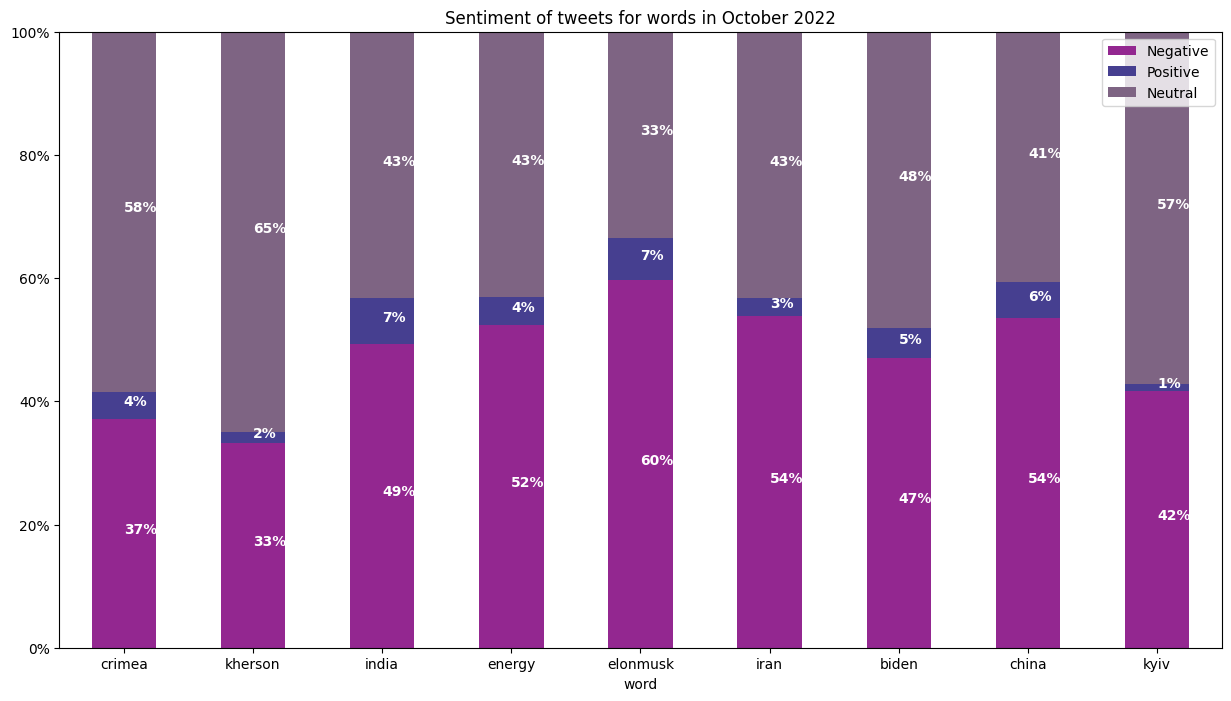

In [51]:
# plot stacked bar chart of interesting words from each sentiment using counters
def plot_stacked_bar_chart(
    interesting_words,
    counter_neg,
    counter_pos,
    counter_neu,
    colors=colors,
    figsize=(15, 8),
):
    # create dataframe
    df = pd.DataFrame(
        {
            "word": interesting_words,
            "negative": [counter_neg[word] for word in interesting_words],
            "positive": [counter_pos[word] for word in interesting_words],
            "neutral": [counter_neu[word] for word in interesting_words],
        }
    )
    df["total"] = df["negative"] + df["positive"] + df["neutral"]
    # set index to word
    df = df.set_index("word")

    # calculate % of each sentiment for each word
    df["neg_percent"] = df["negative"] / df["total"]
    df["pos_percent"] = df["positive"] / df["total"]
    df["neu_percent"] = df["neutral"] / df["total"]

    # df.plot.bar(stacked=True, figsize=(15, 5))
    df[["neg_percent", "pos_percent", "neu_percent"]].plot.bar(
        stacked=True,
        figsize=figsize,
        color=[
            colors[Sentiment.NEGATIVE],
            colors[Sentiment.POSITIVE],
            colors[Sentiment.NEUTRAL],
        ],
    )

    # add the % on top of the bars
    for i, v in enumerate(df["neg_percent"]):
        plt.text(i, v / 2, f"{v:.0%}", color="white", fontweight="bold")
    for i, v in enumerate(df["pos_percent"]):
        plt.text(
            i,
            v / 2 + df["neg_percent"][i],
            f"{v:.0%}",
            color="white",
            fontweight="bold",
        )
    for i, v in enumerate(df["neu_percent"]):
        plt.text(
            i,
            v / 2 + df["neg_percent"][i] + df["pos_percent"][i],
            f"{v:.0%}",
            color="white",
            fontweight="bold",
        )

    # legend
    plt.legend(loc="best", labels=["Negative", "Positive", "Neutral"])
    plt.ylim(0, 1)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # make x axis labels horizontal
    plt.xticks(rotation=0)
    # title
    plt.title(f"Sentiment of tweets for words in {MONTH} 2022")
    plt.show()


interesting_words = "crimea kherson india energy elonmusk iran biden china kyiv".split()
# plot the stacked bar chart
plot_stacked_bar_chart(interesting_words, counter_neg, counter_pos, counter_neu)


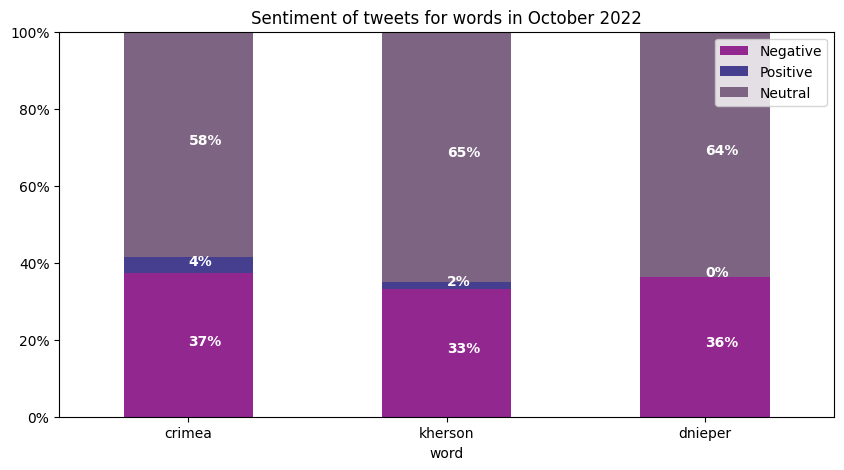

In [52]:
interesting_words = "crimea kherson dnieper".split()
# plot the stacked bar chart
plot_stacked_bar_chart(
    interesting_words, counter_neg, counter_pos, counter_neu, figsize=(10, 5)
)


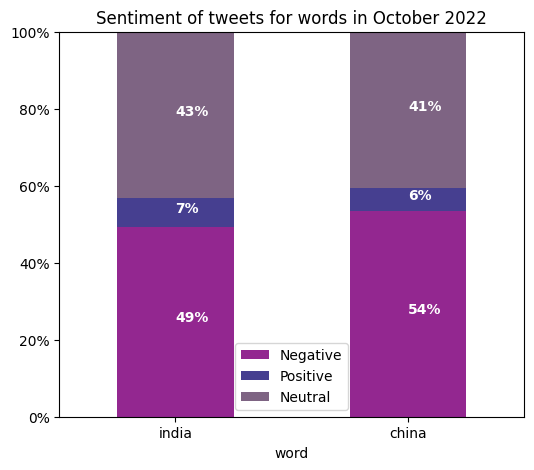

In [53]:
interesting_words = "india china".split()
# plot the stacked bar chart
plot_stacked_bar_chart(
    interesting_words, counter_neg, counter_pos, counter_neu, figsize=(6, 5)
)


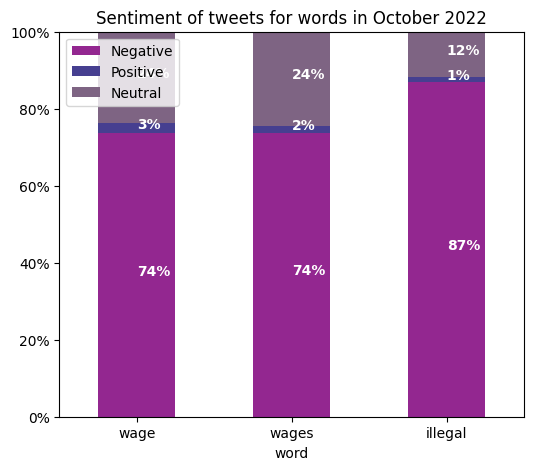

In [54]:
interesting_words = "wage wages illegal".split()
# plot the stacked bar chart
plot_stacked_bar_chart(
    interesting_words, counter_neg, counter_pos, counter_neu, figsize=(6, 5)
)


In [55]:
# function to get top n-grams
# import countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

# import tokenizer
from nltk.tokenize import word_tokenize
import string
import re

words_for_bigrams = "war putin nato usa sir sirs".split(" ")

# remove words from stop words
for w in words_for_bigrams:
    if w in stopwords:
        stopwords.remove(w)

# function to clean text
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split("\W+", text)
    text = [word for word in tokens if word not in stopwords]
    return text


def get_top_n_ngram(corpus, ngram=2, n=None, stop_words=None):
    vec = CountVectorizer(
        ngram_range=(ngram, ngram), stop_words=stop_words, tokenizer=clean_text
    ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


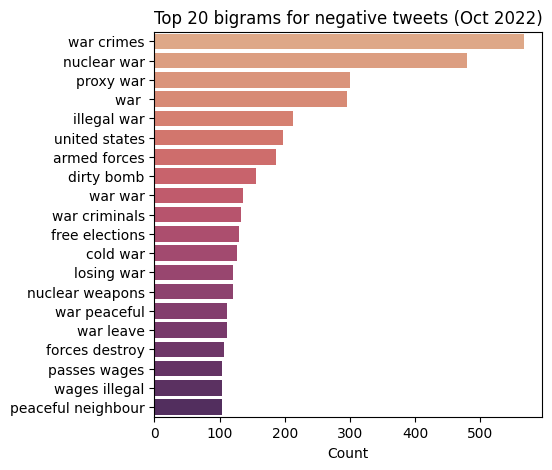

In [56]:
# top bigrams for negative tweets
top_bigrams_neg = get_top_n_ngram(
    df[df["Sentiment"] == Sentiment.NEGATIVE.name]["cleaned_text"].dropna(),
    ngram=2,
    n=20,
    stop_words=stopwords,
)

x, y = map(list, zip(*top_bigrams_neg))

# set color palette
# sns.set_palette(sns.color_palette("flare"))
plt.figure(figsize=(5, 5))
sns.barplot(x=y, y=x, palette=sns.color_palette("flare", 20))
plt.xlabel("Count")
plt.title(f"Top 20 bigrams for negative tweets ({MONTH[:3]} 2022)")
plt.show()


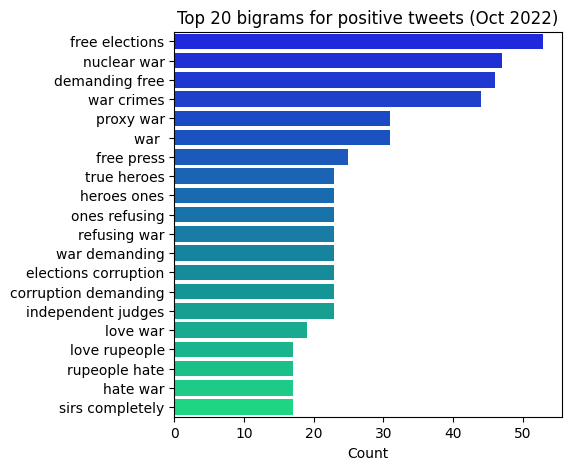

In [57]:
# top bigrams for positive tweets
top_bigrams_pos = get_top_n_ngram(
    df[df["Sentiment"] == Sentiment.POSITIVE.name]["cleaned_text"].dropna(),
    ngram=2,
    n=20,
    stop_words=stopwords,
)

x, y = map(list, zip(*top_bigrams_pos))

# set color palette
plt.figure(figsize=(5, 5))
sns.barplot(x=y, y=x, palette=sns.color_palette("winter", 20))
plt.xlabel("Count")
plt.title(f"Top 20 bigrams for positive tweets ({MONTH[:3]} 2022)")
plt.show()


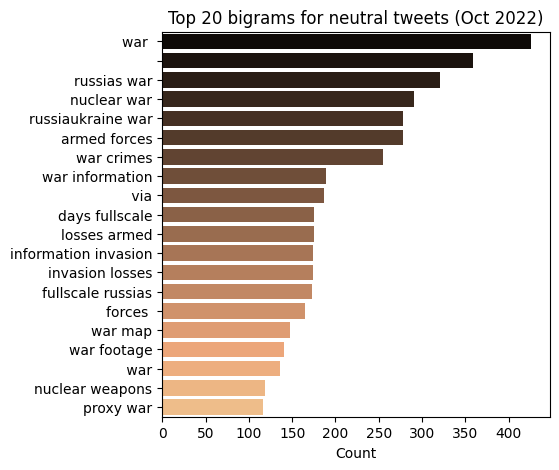

In [58]:
# top bigrams for neutral tweets
top_bigrams_neu = get_top_n_ngram(
    df[df["Sentiment"] == Sentiment.NEUTRAL.name]["cleaned_text"].dropna(),
    ngram=2,
    n=20,
    stop_words=stopwords,
)

x, y = map(list, zip(*top_bigrams_neu))

# set color palette
plt.figure(figsize=(5, 5))
plt.xlabel("Count")
sns.barplot(x=y, y=x, palette=sns.color_palette("copper", 20))
plt.title(f"Top 20 bigrams for neutral tweets ({MONTH[:3]} 2022)")
plt.show()


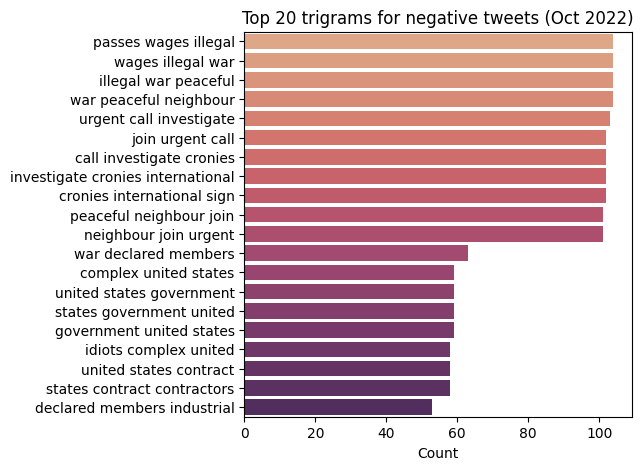

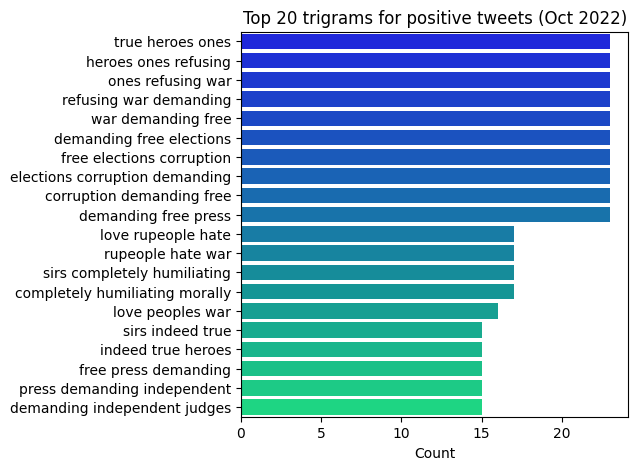

In [59]:
# top trigrams for negative tweets
top_trigrams_neg = get_top_n_ngram(
    df[df["Sentiment"] == Sentiment.NEGATIVE.name]["cleaned_text"].dropna(),
    ngram=3,
    n=20,
    stop_words=stopwords,
)

x, y = map(list, zip(*top_trigrams_neg))

# set color palette
plt.figure(figsize=(5, 5))
sns.barplot(x=y, y=x, palette=sns.color_palette("flare", 20))
plt.xlabel("Count")
plt.title(f"Top 20 trigrams for negative tweets ({MONTH[:3]} 2022)")
plt.show()

# top trigrams for positive tweets
top_trigrams_pos = get_top_n_ngram(
    df[df["Sentiment"] == Sentiment.POSITIVE.name]["cleaned_text"].dropna(),
    ngram=3,
    n=20,
    stop_words=stopwords,
)

x, y = map(list, zip(*top_trigrams_pos))

# set color palette
plt.figure(figsize=(5, 5))
sns.barplot(x=y, y=x, palette=sns.color_palette("winter", 20))
plt.xlabel("Count")
plt.title(f"Top 20 trigrams for positive tweets ({MONTH[:3]} 2022)")
plt.show()


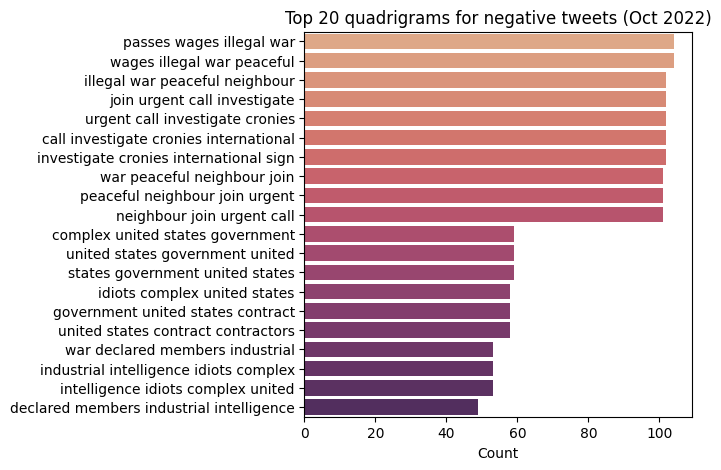

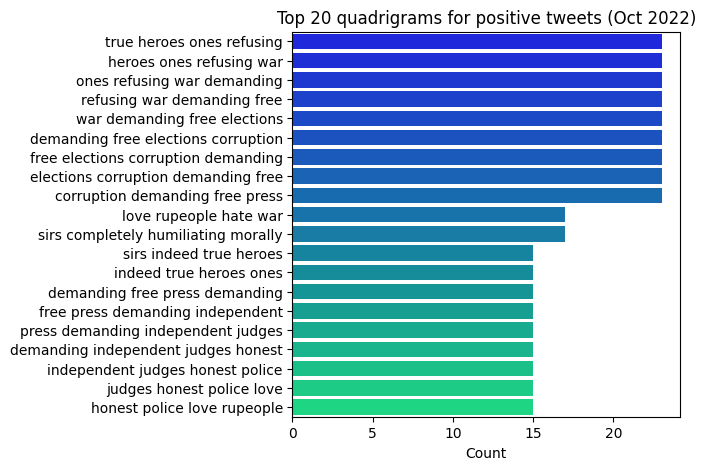

In [60]:
# top quadrigrams for negative tweets
top_quadrigrams_neg = get_top_n_ngram(
    df[df["Sentiment"] == Sentiment.NEGATIVE.name]["cleaned_text"].dropna(),
    ngram=4,
    n=20,
    stop_words=stopwords,
)

x, y = map(list, zip(*top_quadrigrams_neg))

# set color palette
plt.figure(figsize=(5, 5))
sns.barplot(x=y, y=x, palette=sns.color_palette("flare",20))
plt.xlabel("Count")
plt.title(f"Top 20 quadrigrams for negative tweets ({MONTH[:3]} 2022)")
plt.show()

# top quadrigrams for positive tweets
top_quadrigrams_pos = get_top_n_ngram(
    df[df["Sentiment"] == Sentiment.POSITIVE.name]["cleaned_text"].dropna(),
    ngram=4,
    n=20,
    stop_words=stopwords,
)

x, y = map(list, zip(*top_quadrigrams_pos))

# set color palette
plt.figure(figsize=(5, 5))
sns.barplot(x=y, y=x, palette=sns.color_palette("winter",20))
plt.xlabel("Count")
plt.title(f"Top 20 quadrigrams for positive tweets ({MONTH[:3]} 2022)")
plt.show()

    

In [61]:
# one tweet example for each sentiment containing the most common bigrams
for word in top_common_words:
    # print a positive tweet containing the word
    try:
        print(
            "Positive tweet containing the word '{}':".format(word),
            df[
                (df["Sentiment"] == Sentiment.POSITIVE.name)
                & (df["cleaned_text"].str.contains(word))
            ]["Tweet"].values[0],
        )
        print("-" * 100)
        print(
            "Negative tweet containing the word '{}':".format(word),
            df[
                (df["Sentiment"] == Sentiment.NEGATIVE.name)
                & (df["cleaned_text"].str.contains(word))
            ]["Tweet"].values[0],
        )
        print("=" * 100)
    except IndexError:
        pass


Positive tweet containing the word 'via': #Russia #Ukraine #Crimea #War #Donbass #SpecialMilitaryOperation     
Is Russia Poised To Win The Ukraine War? https://t.co/l060WcJPTy via @YouTube
----------------------------------------------------------------------------------------------------
Negative tweet containing the word 'via': So while engaging #Russia via #Ukraine, the #US is firing up war talk with Iran and provoking #China. Power-hungry sickos.
Positive tweet containing the word 'uk': Is this a good idea?

"These inspectors in Ukraine appear to be some of the first members of the U.S. military to re-enter the Eastern European country since the start of the war,"

#Ukraine #Kyiv #Kherson #Donetsk #Crimea #Russia #NATO #POTUS 
https://t.co/8iMnt9LqMc
----------------------------------------------------------------------------------------------------
Negative tweet containing the word 'uk': What is striking is Ukraine wants this to be a more visual media war whereupon Russia want t